<a href="https://colab.research.google.com/github/elijahcw-git/Capstone/blob/main/Crime_Hotspot_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install category_encoders

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.3 MB/s eta 0:00:00


In [3]:
#Import dataset:

crime_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/crime_clean.csv')
print(crime_df.shape)

(2883802, 26)


In [4]:
crime_df.columns

Index(['DR_NO', 'Date_Rptd', 'DATE_OCC', 'TIME_OCC', 'AREA', 'AREA_NAME',
       'Rpt_Dist_No', 'Part_1-2', 'Crm_Cd', 'Crm_Cd_Desc', 'Vict_Age',
       'Vict_Sex', 'Vict_Descent', 'LOCATION', 'LAT', 'LON', 'Avg_Temp',
       'Avg_Dewpoint', 'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure',
       'Total_Precipitation', 'Weapon_Reported', 'Crime_Category',
       'Crime_Category_Code', 'Region_Ethnic_Origin'],
      dtype='object')

In [5]:
print(f"Dataset shape :{crime_df.shape}\n")


missing_values = crime_df.isnull().sum()
percentage_missing = (missing_values / len(crime_df)) * 100
unique_values = crime_df.nunique()
summary_df = print(pd.DataFrame({'Data_type': crime_df.dtypes,'Missing': missing_values, '%_Missing': percentage_missing, 'Unique_values': unique_values}))

print(summary_df)

Dataset shape :(2883802, 26)

                     Data_type  Missing  %_Missing  Unique_values
DR_NO                    int64        0        0.0        2555000
Date_Rptd               object        0        0.0           5129
DATE_OCC                object        0        0.0           5111
TIME_OCC                 int64        0        0.0           1439
AREA                     int64        0        0.0             21
AREA_NAME               object        0        0.0             21
Rpt_Dist_No              int64        0        0.0           1302
Part_1-2                 int64        0        0.0              2
Crm_Cd                   int64        0        0.0            144
Crm_Cd_Desc             object        0        0.0            144
Vict_Age               float64        0        0.0             99
Vict_Sex                object        0        0.0              3
Vict_Descent            object        0        0.0             21
LOCATION                object        0       

In [6]:
crime_df['DATE_OCC'] = pd.to_datetime(crime_df['DATE_OCC'])
crime_df.head(5)

,DR_NO,Date_Rptd,DATE_OCC,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,...,Avg_Temp,Avg_Dewpoint,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin
0,1307355,02/20/2010 12:00:00 AM,2010-02-20,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,56.1,47.5,73.2,9.7,29.8,0.0,0,Violations and Restraining Orders,7,Hispanic/Latin/Mexican
1,100100638,02/20/2010 12:00:00 AM,2010-02-20,100,1,Central,164,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,56.1,47.5,73.2,9.7,29.8,0.0,0,Vandalism and Property Damage,6,Other
2,100100639,02/20/2010 12:00:00 AM,2010-02-20,230,1,Central,164,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,56.1,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican
3,100106650,02/20/2010 12:00:00 AM,2010-02-20,45,1,Central,155,2,624,BATTERY - SIMPLE ASSAULT,...,56.1,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black
4,100106654,02/20/2010 12:00:00 AM,2010-02-20,1130,1,Central,146,2,946,OTHER MISCELLANEOUS CRIME,...,56.1,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican


In [7]:
# Convert the following into categorical

crime_df['AREA_NAME'] = crime_df['AREA_NAME'].astype('category')

In [8]:
crime_df['Crime_Incidence'] = crime_df.groupby(['AREA_NAME', 'DATE_OCC'])['AREA_NAME'].transform('count')

In [9]:
area_mapping = {
    'Central': 'Central_Bureau', 'Hollenbeck': 'Central_Bureau', 'Newton': 'Central_Bureau', 'Northeast': 'Central_Bureau', 'Rampart': 'Central_Bureau',
    '77th Street': 'South_Bureau', 'Harbor': 'South_Bureau', 'Southeast': 'South_Bureau', 'Southwest': 'South_Bureau',
    'Hollywood': 'West_Bureau', 'Olympic': 'West_Bureau', 'Pacific': 'West_Bureau', 'West Los Angeles': 'West_Bureau', 'Wilshire': 'West_Bureau',
    'Devonshire': 'Valley_Bureau', 'Foothill': 'Valley_Bureau', 'Mission': 'Valley_Bureau', 'N Hollywood': 'Valley_Bureau', 'Topanga': 'Valley_Bureau', 'Van Nuys': 'Valley_Bureau', 'West Valley': 'Valley_Bureau',
}
# Creating the new variable, BUREAU.

crime_df['BUREAU'] = crime_df['AREA_NAME'].map(area_mapping)

In [10]:
crime_df.shape

(2883802, 28)

In [11]:
# Convert the following into categorical

crime_df['BUREAU'] = crime_df['BUREAU'].astype('category')

In [12]:
crime_df['BUREAU'].value_counts()

Valley_Bureau     898134
Central_Bureau    669719
South_Bureau      640506
West_Bureau       548001
Name: BUREAU, dtype: int64

<Figure size 1200x600 with 0 Axes>

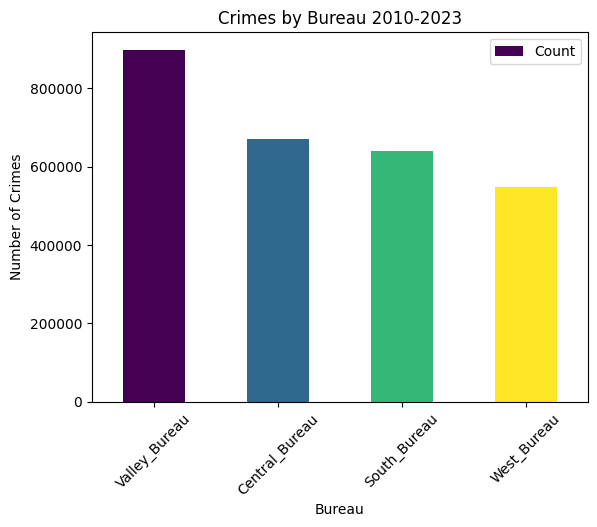

In [13]:
# Group by BUREAU and count the number of crimes
crimes_by_bureau = crime_df.groupby('BUREAU')['DR_NO'].count().reset_index(name='Count')


# Sort by crime count
crimes_by_bureau = crimes_by_bureau.sort_values('Count', ascending=False)

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(crimes_by_bureau)))

# Create a bar chart
plt.figure(figsize=(12, 6))
crimes_by_bureau.plot(kind='bar', x='BUREAU', y='Count', color=colors)

# Add labels and title
plt.title('Crimes by Bureau 2010-2023')
plt.xlabel('Bureau')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()


In [14]:
# To split crime_df into four separate datasets based on bureau category.

split_datasets = {}

categories = crime_df['BUREAU'].unique()
for category in categories:
  split_datasets[category] = crime_df[crime_df['BUREAU'] ==category]

central_dataset = split_datasets['Central_Bureau']
west_dataset = split_datasets['West_Bureau']
south_dataset = split_datasets['South_Bureau']
valley_dataset = split_datasets['Valley_Bureau']

In [15]:
south_dataset.head()

,DR_NO,Date_Rptd,DATE_OCC,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,...,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin,Crime_Incidence,BUREAU
49,100300676,02/20/2010 12:00:00 AM,2010-02-20,40,3,Southwest,362,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,42,South_Bureau
50,100300678,02/20/2010 12:00:00 AM,2010-02-20,1640,3,Southwest,363,1,310,BURGLARY,...,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Black,42,South_Bureau
51,100300680,02/20/2010 12:00:00 AM,2010-02-20,1015,3,Southwest,311,2,624,BATTERY - SIMPLE ASSAULT,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,42,South_Bureau
52,100307420,02/21/2010 12:00:00 AM,2010-02-20,1300,3,Southwest,397,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican,42,South_Bureau
53,100307356,02/20/2010 12:00:00 AM,2010-02-20,145,3,Southwest,363,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,42,South_Bureau


**Using Neural Network's LSTM in TensorFlow to Predict Crime Incidence (Hotspot)**

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import mean_squared_error
import math
from math import floor,ceil,sqrt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

**LSTM for Full Data (All Bureaus)**

In [17]:
def lstm_prediction(crime_df):
    shape=crime_df.shape[0]
    df_new=crime_df[['Crime_Incidence']]
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]

    print('---------------------------------------------------------------------------------------')
    print('-----------L.A. CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('---------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC',size=15)
    plt.ylabel('Amount of Crime Incidences',size=15)
    plt.title('L.A. CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)',size=15)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

---------------------------------------------------------------------------------------
-----------L.A. CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
---------------------------------------------------------------------------------------
Shape of Training Set (2307042, 1)
Shape of Validation Set (576760, 1)
Epoch 1/50
57676/57676 - 336s - loss: 0.0013 - val_loss: 6.6691e-04 - 336s/epoch - 6ms/step
Epoch 2/50
57676/57676 - 328s - loss: 0.0012 - val_loss: 6.6795e-04 - 328s/epoch - 6ms/step
Epoch 3/50
57676/57676 - 330s - loss: 0.0012 - val_loss: 6.5964e-04 - 330s/epoch - 6ms/step
Epoch 4/50
57676/57676 - 328s - loss: 0.0012 - val_loss: 6.6640e-04 - 328s/epoch - 6ms/step
Epoch 5/50
57676/57676 - 329s - loss: 0.0012 - val_loss: 6.6701e-04 - 329s/epoch - 6ms/step
Epoch 6/50
57676/57676 - 329s - loss: 0.0012 - val_loss: 6.5986e-04 - 329s/epoch - 6ms/step
Epoch 7/50
57676/57676 - 329s - loss: 0.0012 - val_loss: 6.5893e-04 - 329s/epoch - 6ms/step
Epoch 8/50
57676/57676

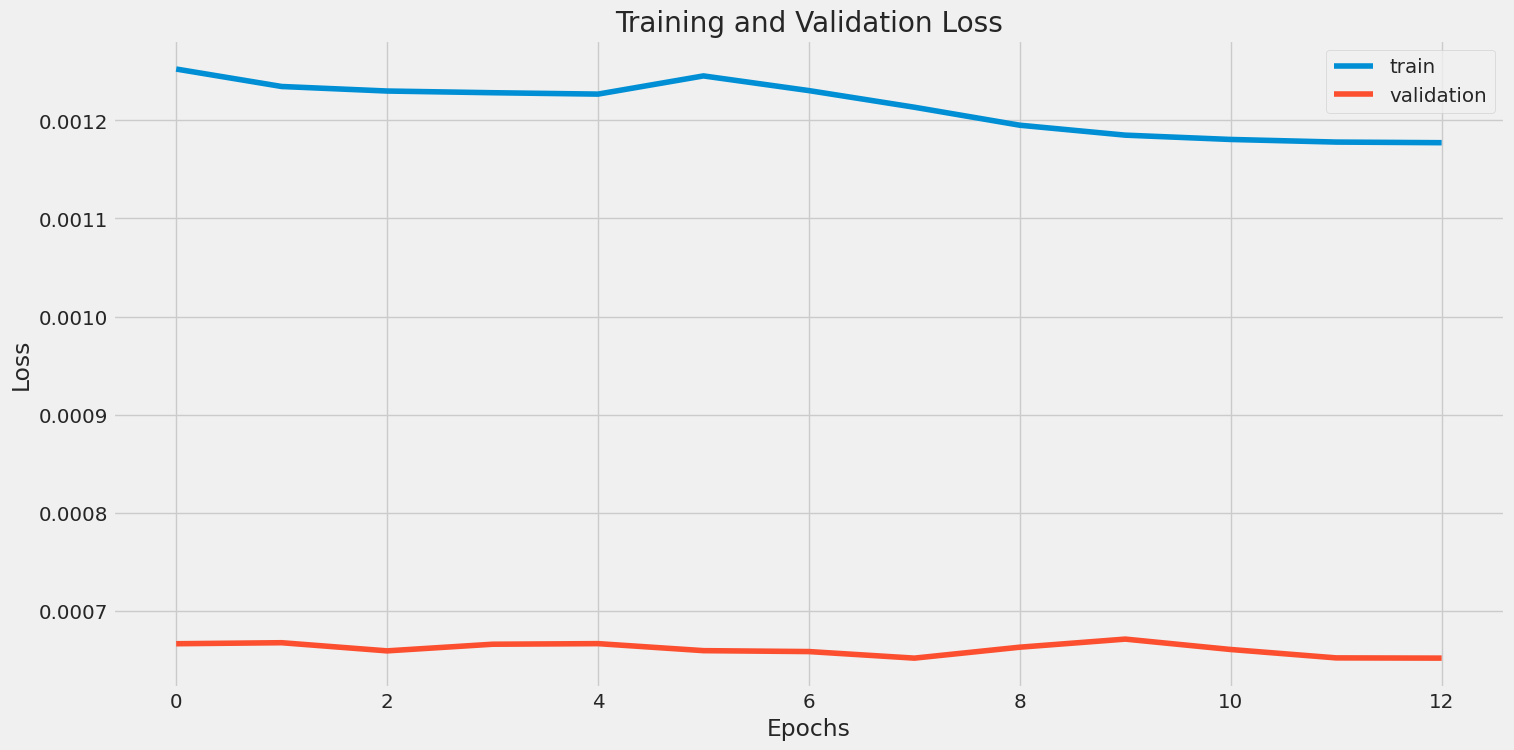

18024/18024 [==============================] - 47s 3ms/step
RMSE value on validation set: Crime_Incidence    16.564988
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


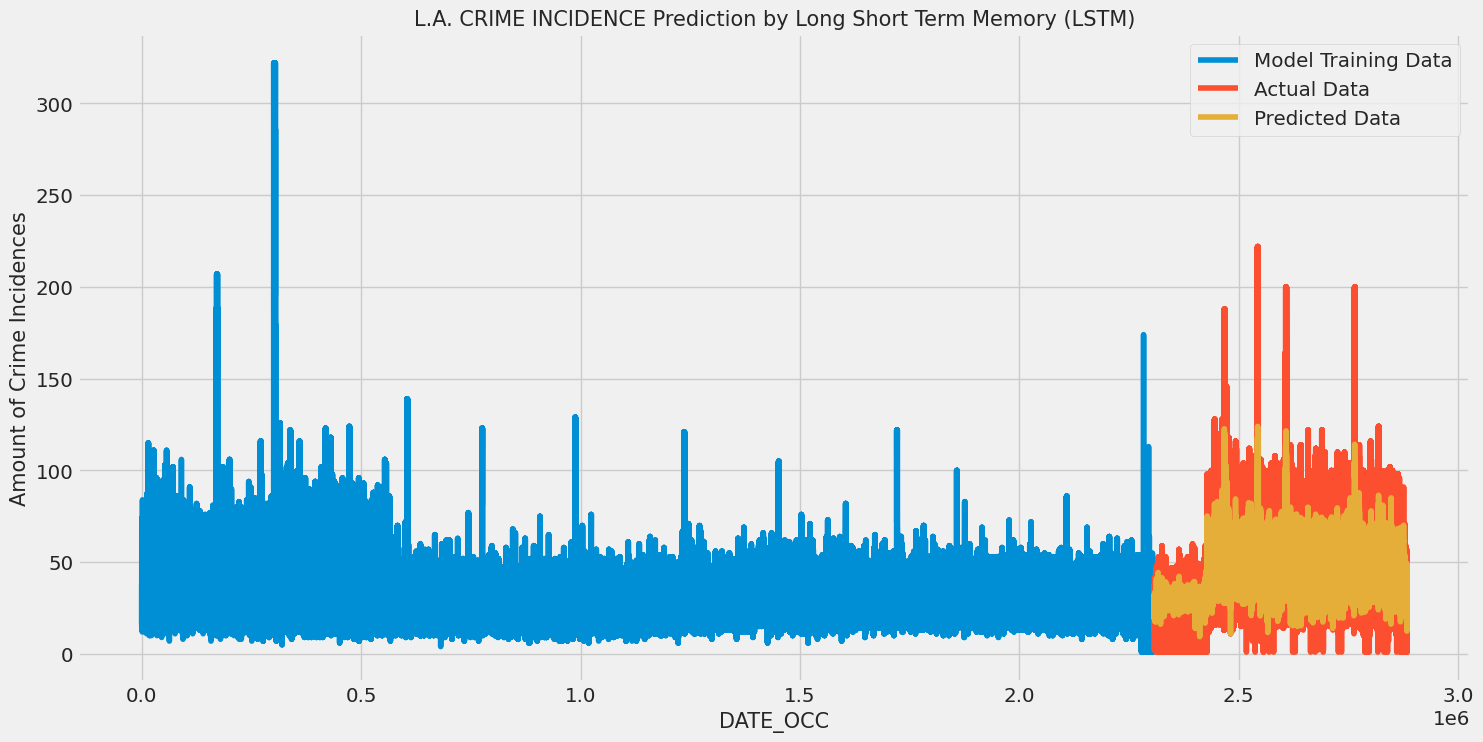

In [18]:
lstm_prediction(crime_df)

**LSTM for West Bureau**

In [19]:
def lstm_prediction(west_dataset):
    shape=west_dataset.shape[0]
    df_new=west_dataset[['Crime_Incidence']]
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]

    print('---------------------------------------------------------------------------------------')
    print('-----------WEST BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('---------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC',size=15)
    plt.ylabel('Amount of Crime Incidences',size=15)
    plt.title('WEST BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT Prediction by Long Short Term Memory (LSTM)',size=15)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

---------------------------------------------------------------------------------------
-----------WEST BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
---------------------------------------------------------------------------------------
Shape of Training Set (438401, 1)
Shape of Validation Set (109600, 1)
Epoch 1/50
10959/10959 - 63s - loss: 0.0018 - val_loss: 9.7995e-04 - 63s/epoch - 6ms/step
Epoch 2/50
10959/10959 - 59s - loss: 0.0018 - val_loss: 9.3919e-04 - 59s/epoch - 5ms/step
Epoch 3/50
10959/10959 - 59s - loss: 0.0018 - val_loss: 9.2582e-04 - 59s/epoch - 5ms/step
Epoch 4/50
10959/10959 - 59s - loss: 0.0018 - val_loss: 9.5983e-04 - 59s/epoch - 5ms/step
Epoch 5/50
10959/10959 - 59s - loss: 0.0018 - val_loss: 9.3192e-04 - 59s/epoch - 5ms/step
Epoch 6/50
10959/10959 - 59s - loss: 0.0017 - val_loss: 9.6053e-04 - 59s/epoch - 5ms/step
Epoch 7/50
10959/10959 - 59s - loss: 0.0017 - val_loss: 8.9364e-04 - 59s/epoch - 5ms/step
Epoch 8/50
109

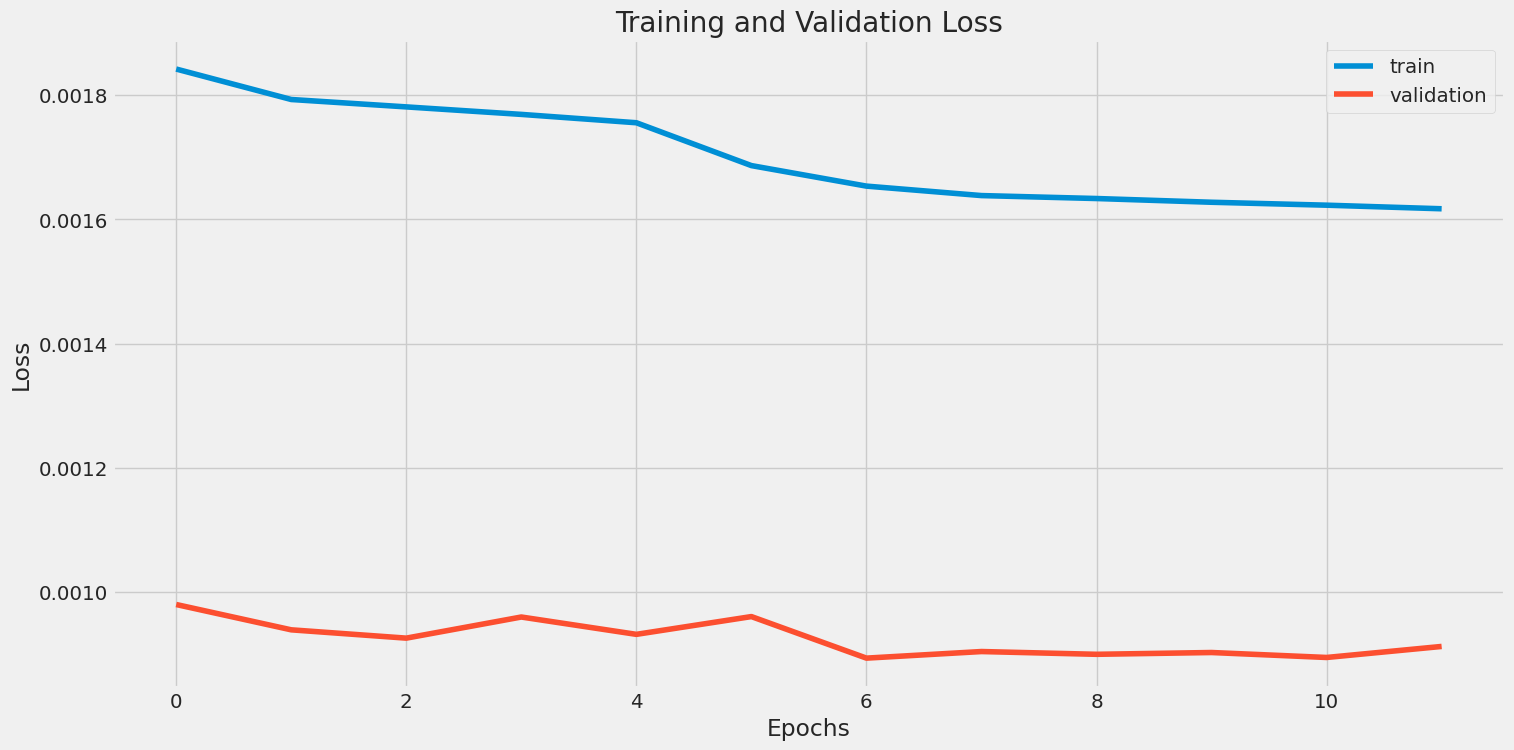

3425/3425 [==============================] - 9s 3ms/step
RMSE value on validation set: Crime_Incidence    13.035592
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


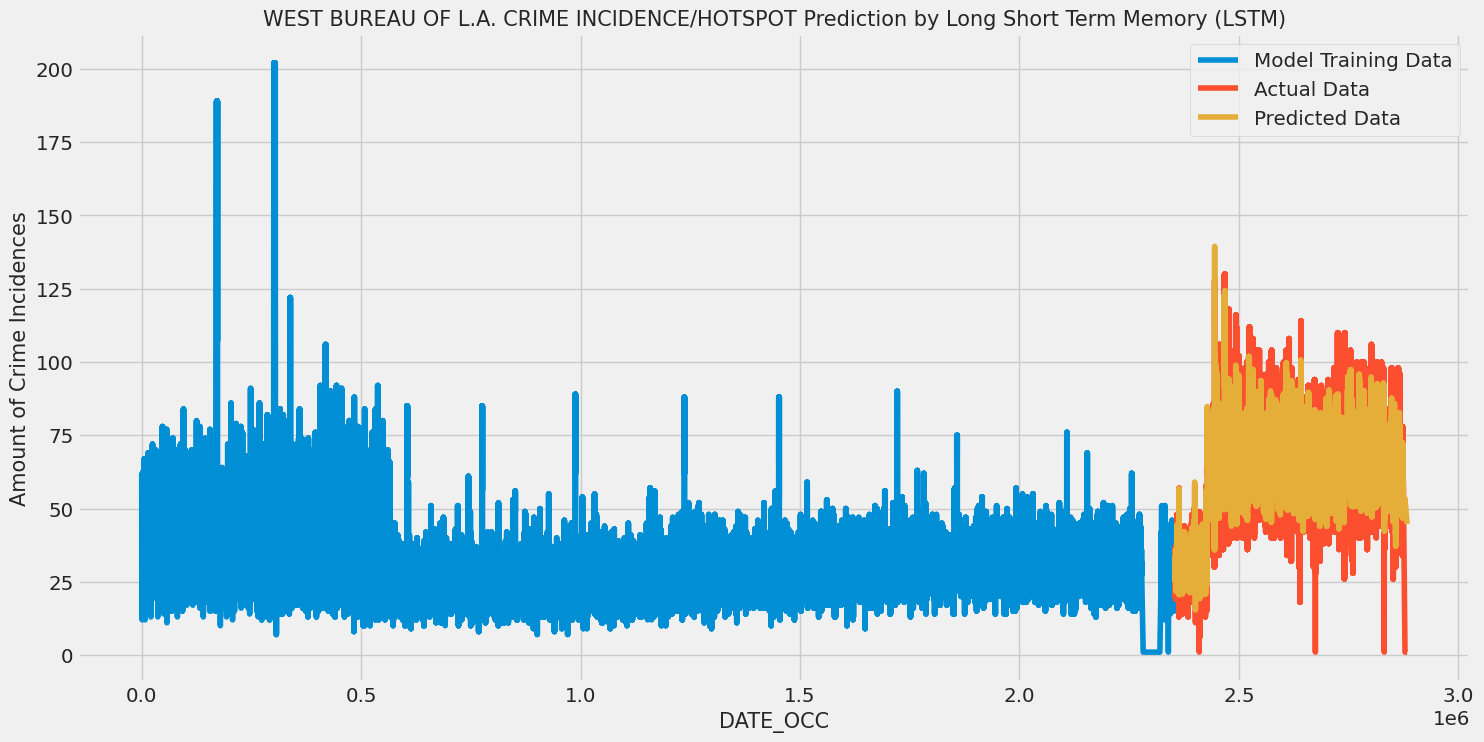

In [20]:
lstm_prediction(west_dataset)

**LSTM for South Bureau**

In [21]:
def lstm_prediction(south_dataset):
    shape=south_dataset.shape[0]
    df_new=south_dataset[['Crime_Incidence']]
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]

    print('---------------------------------------------------------------------------------------')
    print('-----------SOUTH BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('---------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC',size=15)
    plt.ylabel('Amount of Crime Incidences',size=15)
    plt.title('SOUTH BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT Prediction by Long Short Term Memory (LSTM)',size=15)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

---------------------------------------------------------------------------------------
-----------SOUTH BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
---------------------------------------------------------------------------------------
Shape of Training Set (512405, 1)
Shape of Validation Set (128101, 1)
Epoch 1/50
12810/12810 - 81s - loss: 0.0018 - val_loss: 0.0011 - 81s/epoch - 6ms/step
Epoch 2/50
12810/12810 - 77s - loss: 0.0018 - val_loss: 0.0011 - 77s/epoch - 6ms/step
Epoch 3/50
12810/12810 - 76s - loss: 0.0017 - val_loss: 0.0011 - 76s/epoch - 6ms/step
Epoch 4/50
12810/12810 - 77s - loss: 0.0016 - val_loss: 0.0010 - 77s/epoch - 6ms/step
Epoch 5/50
12810/12810 - 76s - loss: 0.0016 - val_loss: 0.0011 - 76s/epoch - 6ms/step
Epoch 6/50
12810/12810 - 76s - loss: 0.0016 - val_loss: 0.0011 - 76s/epoch - 6ms/step
Epoch 7/50
12810/12810 - 75s - loss: 0.0016 - val_loss: 0.0011 - 75s/epoch - 6ms/step
Epoch 8/50
12810/12810 - 75s - loss: 0.00

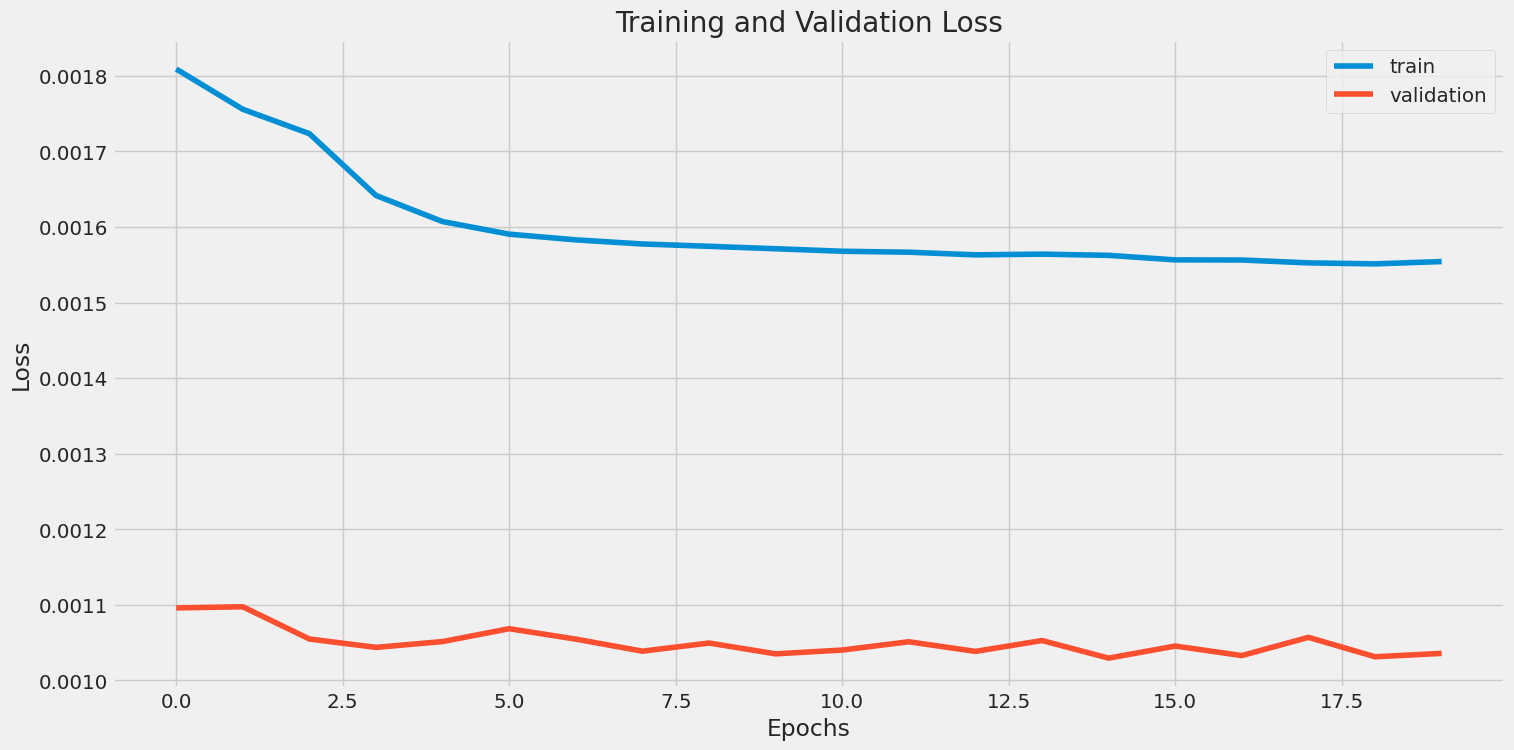

4004/4004 [==============================] - 11s 3ms/step
RMSE value on validation set: Crime_Incidence    17.524334
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


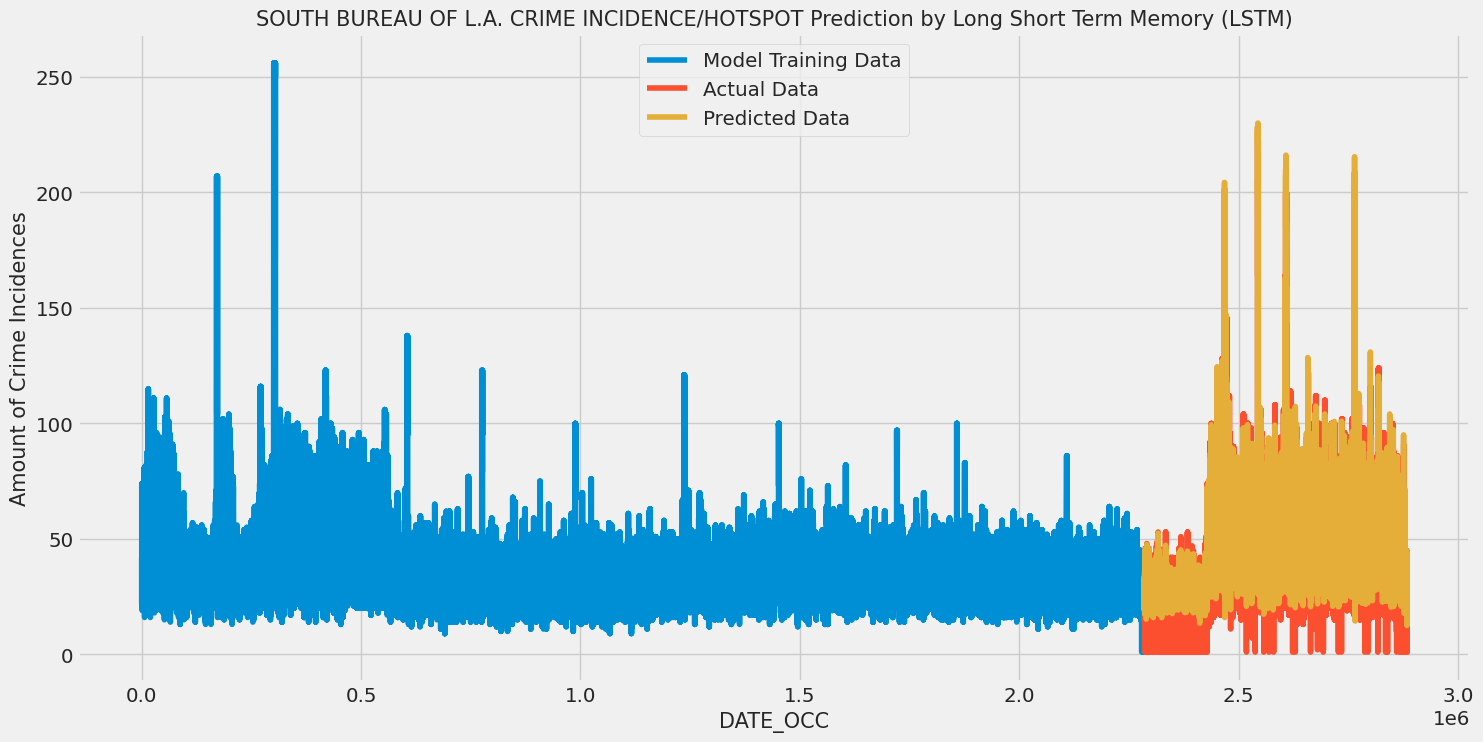

In [22]:
lstm_prediction(south_dataset)

**LSTM for Central Bureau**

In [23]:
def lstm_prediction(central_dataset):
    shape=central_dataset.shape[0]
    df_new=central_dataset[['Crime_Incidence']]
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]

    print('---------------------------------------------------------------------------------------')
    print('-----------CENTRAL BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('---------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC',size=15)
    plt.ylabel('Amount of Crime Incidences',size=15)
    plt.title('CENTRAL BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT Prediction by Long Short Term Memory (LSTM)',size=15)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

---------------------------------------------------------------------------------------
-----------CENTRAL BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
---------------------------------------------------------------------------------------
Shape of Training Set (535776, 1)
Shape of Validation Set (133943, 1)
Epoch 1/50
13394/13394 - 81s - loss: 0.0022 - val_loss: 0.0018 - 81s/epoch - 6ms/step
Epoch 2/50
13394/13394 - 77s - loss: 0.0021 - val_loss: 0.0018 - 77s/epoch - 6ms/step
Epoch 3/50
13394/13394 - 77s - loss: 0.0021 - val_loss: 0.0018 - 77s/epoch - 6ms/step
Epoch 4/50
13394/13394 - 78s - loss: 0.0020 - val_loss: 0.0017 - 78s/epoch - 6ms/step
Epoch 5/50
13394/13394 - 77s - loss: 0.0020 - val_loss: 0.0017 - 77s/epoch - 6ms/step
Epoch 6/50
13394/13394 - 77s - loss: 0.0020 - val_loss: 0.0017 - 77s/epoch - 6ms/step
Epoch 7/50
13394/13394 - 77s - loss: 0.0020 - val_loss: 0.0017 - 77s/epoch - 6ms/step
Epoch 8/50
13394/13394 - 77s - loss: 0.

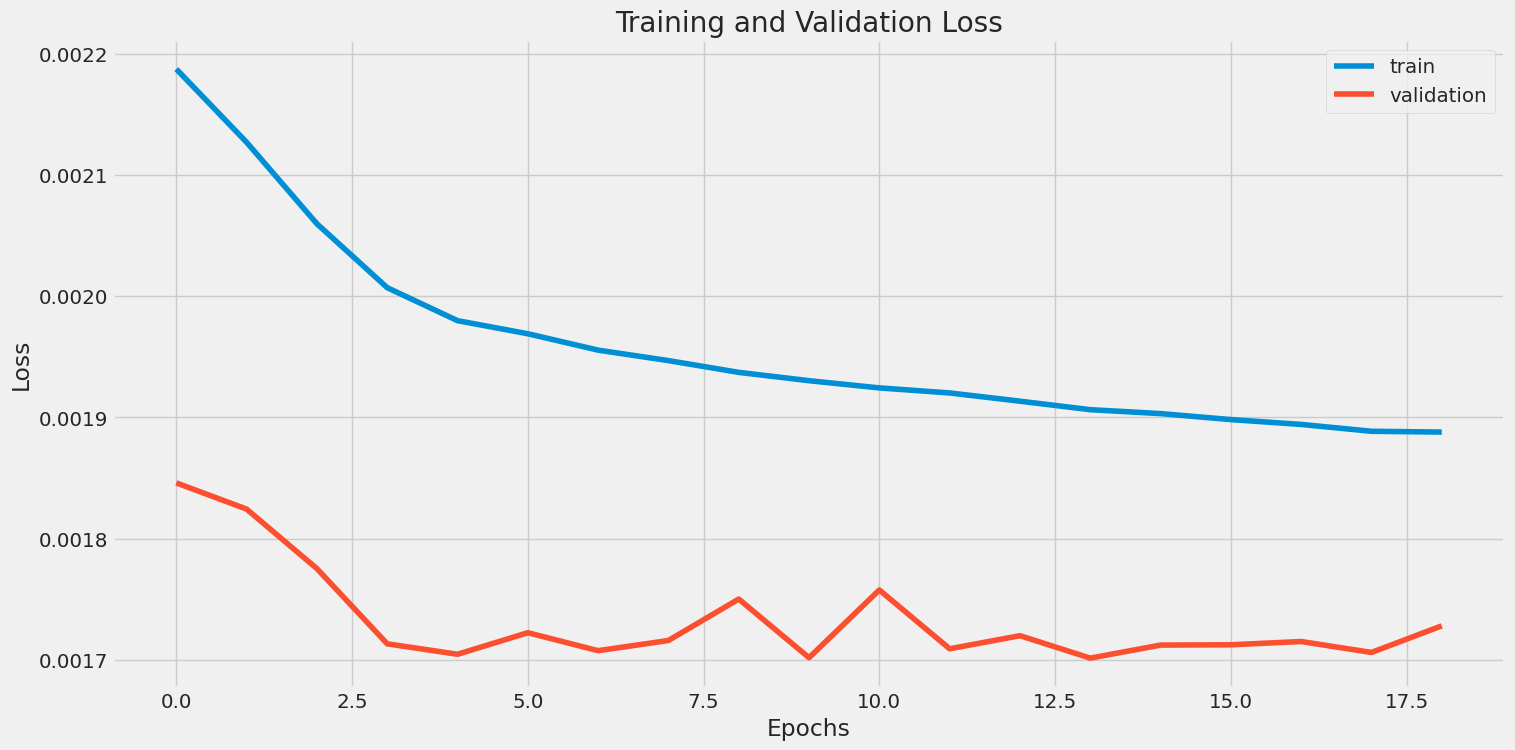

4186/4186 [==============================] - 12s 3ms/step
RMSE value on validation set: Crime_Incidence    15.022775
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


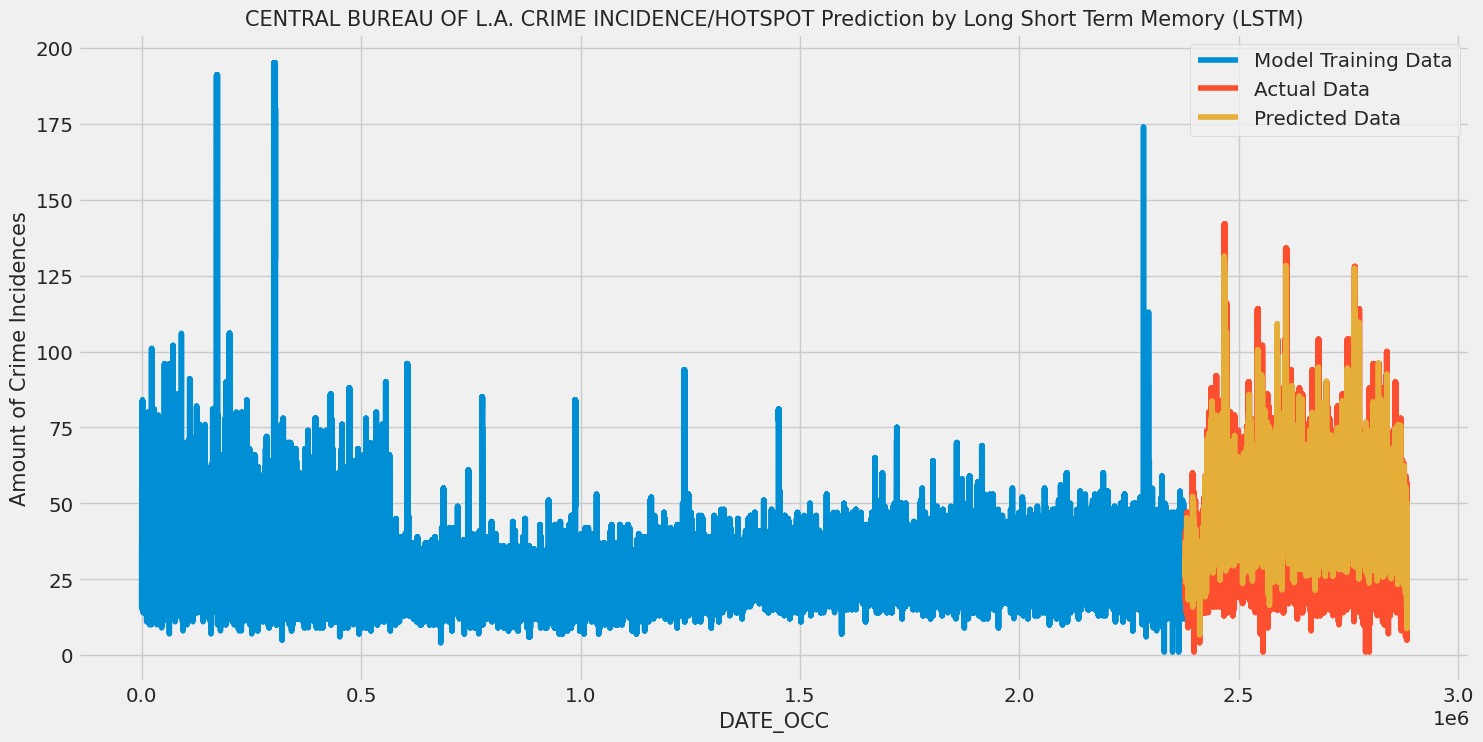

In [24]:
lstm_prediction(central_dataset)

**LSTM for Valley Bureau**

In [25]:
def lstm_prediction(valley_dataset):
    shape=valley_dataset.shape[0]
    df_new=valley_dataset[['Crime_Incidence']]
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]

    print('---------------------------------------------------------------------------------------')
    print('-----------VALLEY BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('---------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC',size=15)
    plt.ylabel('Amount of Crime Incidences',size=15)
    plt.title('VALLEY BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT Prediction by Long Short Term Memory (LSTM)',size=15)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

---------------------------------------------------------------------------------------
-----------VALLEY BUREAU OF L.A. CRIME INCIDENCE/HOTSPOT PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
---------------------------------------------------------------------------------------
Shape of Training Set (718508, 1)
Shape of Validation Set (179626, 1)
Epoch 1/50
17962/17962 - 110s - loss: 1.0000e-03 - val_loss: 4.4541e-04 - 110s/epoch - 6ms/step
Epoch 2/50
17962/17962 - 107s - loss: 9.7074e-04 - val_loss: 4.4135e-04 - 107s/epoch - 6ms/step
Epoch 3/50
17962/17962 - 107s - loss: 9.6341e-04 - val_loss: 4.4374e-04 - 107s/epoch - 6ms/step
Epoch 4/50
17962/17962 - 108s - loss: 9.5643e-04 - val_loss: 4.5116e-04 - 108s/epoch - 6ms/step
Epoch 5/50
17962/17962 - 108s - loss: 9.5291e-04 - val_loss: 4.4037e-04 - 108s/epoch - 6ms/step
Epoch 6/50
17962/17962 - 108s - loss: 9.5114e-04 - val_loss: 4.4309e-04 - 108s/epoch - 6ms/step
Epoch 7/50
17962/17962 - 109s - loss: 9.4869e-04 - val_loss: 4.417

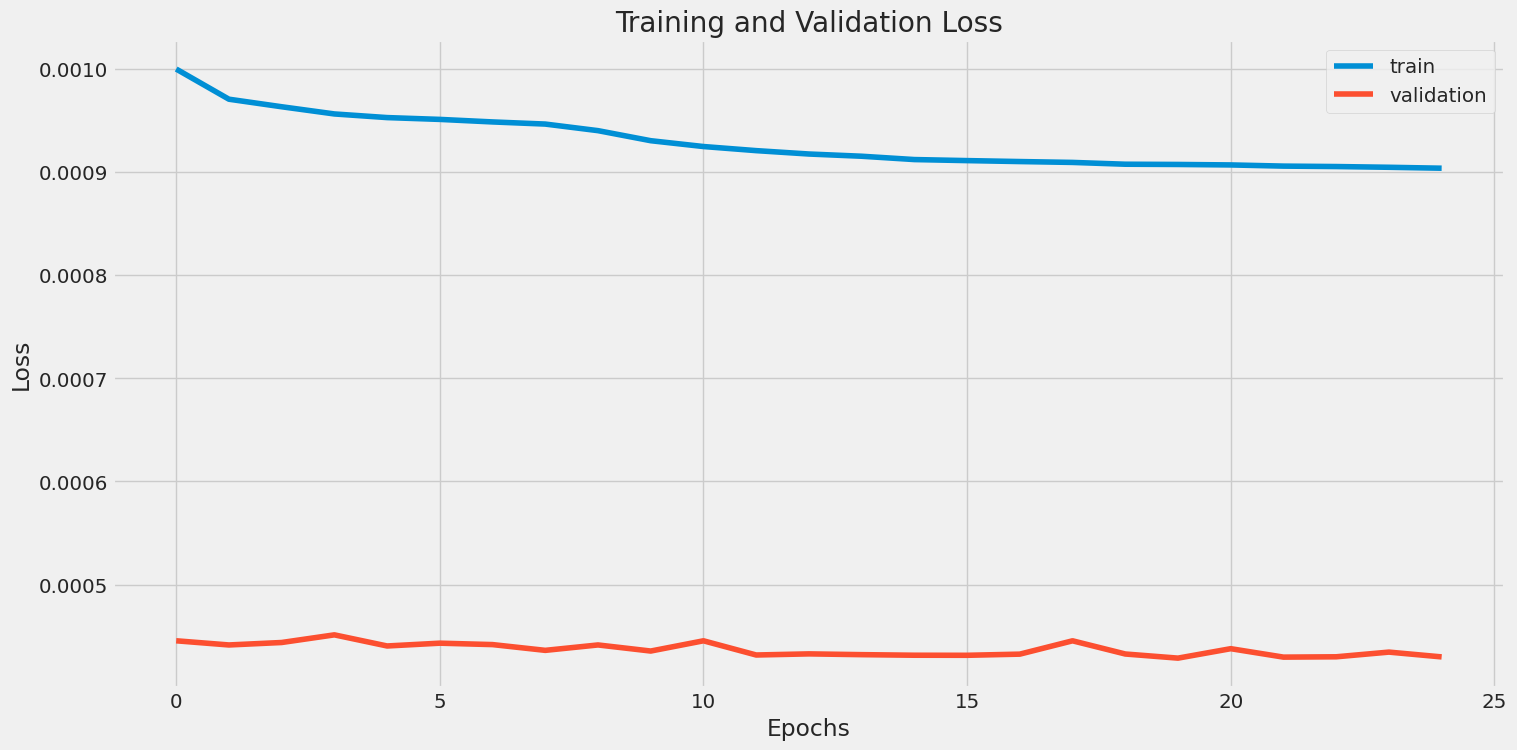

5614/5614 [==============================] - 15s 3ms/step
RMSE value on validation set: Crime_Incidence    11.434609
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


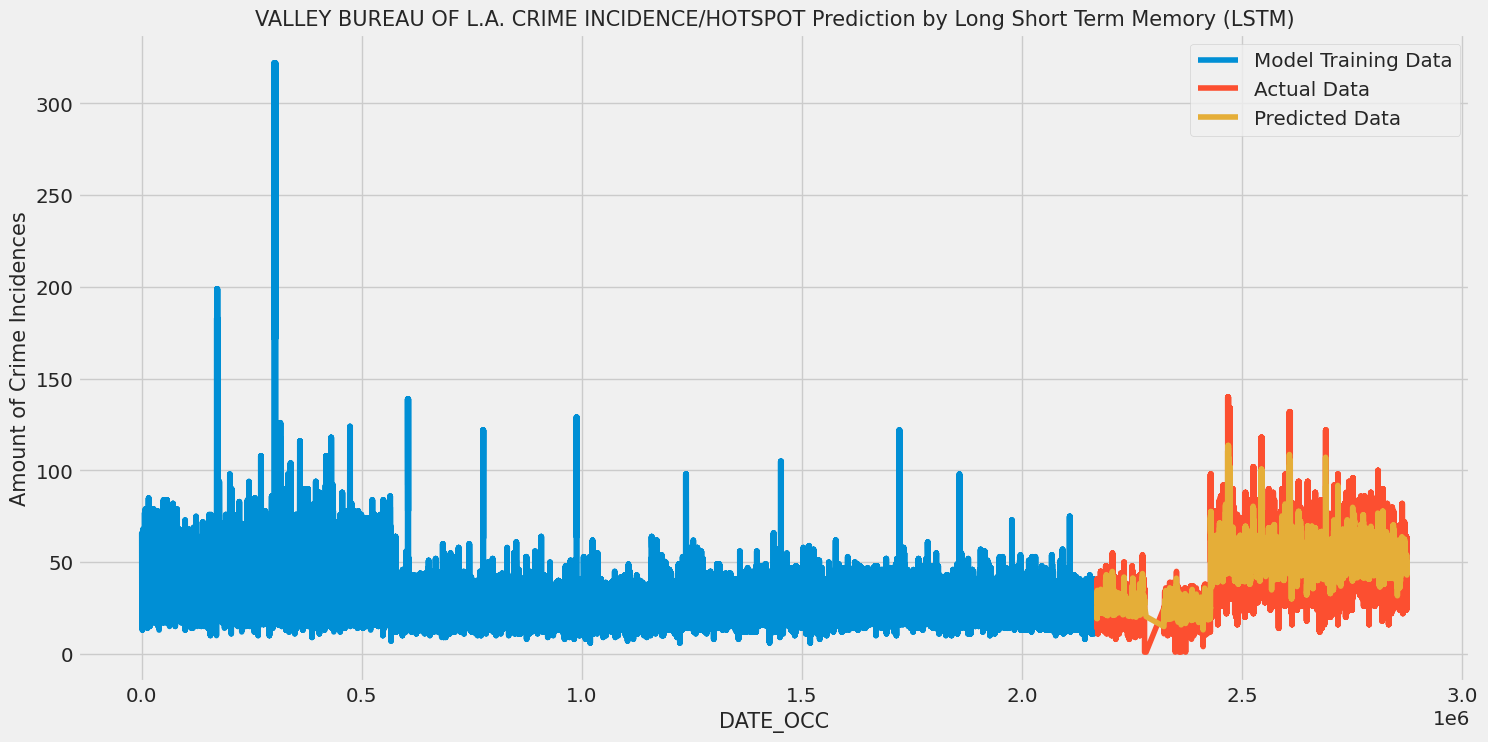

In [26]:
lstm_prediction(valley_dataset)